## A04 Braitenberg Vehicles: Open Ended

This experiment takes place in a 2D space.  There is a Braitenberg vehicle that always starts in the middle of the room (i.e., at the origin x=0,y=0) with a random orientation/heading. The vehicle has two sensors and two motors. The sensors are placed on the left and right of the body of the vehicle and they can sense the intensity of light in their immediate vecinity. The closer a sensor is to the light, the higher the intensity of the sensory stimuli (from 0 dark to 1 light). The motors are placed on the left and right hand sides of the vehicle and can drive the vehicle forward (if both left and right are set to 1), left (if left is set to lower value than right), and right (if right is set to lower value than left). The motors can only be set to values between 0 and 1. During an experiment, a light source is placed at a random location in the environment. The light is placed always the same distance from the vehicle (10 units of space away from the vehicle) but with a different angle (the angle chosen at random). 

The class below implements the vehicle and the light. It is missing the contents of the "think" method, which allow the agent to use the sensory information to make the motors do something. Everything else is implemented.

In [1]:
import numpy as np

In [2]:
class Vehicle:

    def __init__(self):
        
        self.xpos = 0.0                                       # agent's x position, starts in middle of world
        self.ypos = 0.0                                       # agent's y position, starts in middle of world
        self.orientation = np.random.random()*2*np.pi         # agent's orientation, starts at random
        self.velocity = 0.0                                   # agent's velocity, starts at 0
        self.radius = 1.0                                     # the size/radius of the vehicle
        self.leftsensor = 0.0                                 # left sensor value
        self.rightsensor = 0.0                                # right sensor value
        self.leftmotor  = 1.0                                 # left motor output
        self.rightmotor = 1.0                                 # right motor output
        
        # Attributes to determine the placement of the sensors
        self.angleoffset = np.pi/2                                                 # left/right sensor angle offset
        self.rs_xpos = self.radius * np.cos(self.orientation + self.angleoffset)   # right sensor x position
        self.rs_ypos = self.radius * np.sin(self.orientation + self.angleoffset)   # right sensor y position
        self.ls_xpos = self.radius * np.cos(self.orientation - self.angleoffset)   # left sensor x position
        self.ls_ypos = self.radius * np.sin(self.orientation - self.angleoffset)   # left sensor y position

    def sense(self,light):
        # Calculate the distance of the light for each of the sensors
        self.leftsensor = 1 - np.sqrt((self.ls_xpos-light.x)**2 + (self.ls_ypos-light.y)**2)/10
        self.leftsensor = np.clip(self.leftsensor,0,1)
        self.rightsensor = 1 - np.sqrt((self.rs_xpos-light.x)**2 + (self.rs_ypos-light.y)**2)/10
        self.rightsensor = np.clip(self.rightsensor,0,1)
    
    def thinkA(self):
        self.leftmotor = 1 - self.leftsensor
        self.rightmotor = 1 - self.rightsensor
    
    def thinkB(self):
        ## This was useful for arriving at the target, but often the agent would speed past it.
        scaling = 1.0
        self.leftmotor = self.rightsensor * scaling
        self.rightmotor = self.leftsensor * scaling
    
    def thinkC(self):
        self.leftmotor = np.sqrt(self.rightsensor * (1 - self.leftsensor))
        self.rightmotor = np.sqrt(self.leftsensor * (1 - self.rightsensor))

    def think(self, model="c"):
        if model == "a":
            self.thinkA()
        elif model == "b":
            self.thinkB()
        elif model == "c":
            self.thinkC()
        else:
            raise Exception(f"Bad model name `{model}`")
        # clip between 0, 1
        self.leftmotor = np.clip(self.leftmotor,0,1)
        self.rightmotor = np.clip(self.rightmotor,0,1)

    def move(self):
        
        # Update the orientation and velocity of the vehicle based on the left and right motors
        self.rightmotor = np.clip(self.rightmotor,0,1)
        self.leftmotor  = np.clip(self.leftmotor,0,1)
        self.orientation += ((self.leftmotor - self.rightmotor)/10) + np.random.normal(0,0.1)
        self.velocity = ((self.rightmotor + self.leftmotor)/2)/50
        
        # Update position of the agent
        self.xpos += self.velocity * np.cos(self.orientation) 
        self.ypos += self.velocity * np.sin(self.orientation)  
        
        # Update position of the sensors
        self.rs_xpos = self.xpos + self.radius * np.cos(self.orientation + self.angleoffset)
        self.rs_ypos = self.ypos + self.radius * np.sin(self.orientation + self.angleoffset)
        self.ls_xpos = self.xpos + self.radius * np.cos(self.orientation - self.angleoffset)
        self.ls_ypos = self.ypos + self.radius * np.sin(self.orientation - self.angleoffset)

    def distance(self,light):
        return np.sqrt((self.x-light.x)**2 + (self.y-light.y)**2)

class Light:  

    def __init__(self):
        angle = np.random.random()*2*np.pi
        self.x = 10.0 * np.cos(angle)
        self.y = 10.0 * np.sin(angle)

(3 points) Your job is to "wire up" the insides of this Braitenberg vehicle so that it can find the light. That is, your job is to go into the "think" method and set the right and left motors to something, presumably based on the sensory information. In the next cell, tell us how are you going to take in the sensory input and process it or transform it into motor output, so that the vehicle finds the light? Explain your desired solution before writing the code for it. 

In [3]:
# This is a code block, but I'm going to write it in comments anyway so it's
# clear that my response is separate from the question :)

# At first, I wasn't quite sure exactly what was going on here, i.e. how the
# agent would think without being given the light source, but then I saw that
# the think() method would only be called after the sense(Light) method, and
# then that the sense(Light) method would adjust the values of the agent's
# sensors according to the light.
#
# After realizing this, my thought is to adjust the motors' values based on the
# new values of the sensors. There are a couple options here (when I say to
# "wire" A to B, I mean to update the value of A in some way that uses the
# value of B):
#  (a) Wire each motor to the sensor on the same side, or
#  (b) Wire each motor to the sensor on the opposite side, or
#  (c) Wire each motor to both sensors, perhaps as some average of (a) and (b).
# I will implement each of these and try them immediately afterward (by running
# the cell below that displays the plot), and then trying the next one. My
# findings and commentary are below.
#
################################################################################
#
# For (a), it seems like a naive approach like leftmotor = leftsensor would
# cause the agent to turn away from the light source, which is the opposite
# of what we want. So we should change it such that as the sensor of one side
# increases in value, the motor value decreases, so that the agent turns toward
# the light. I'll use motor = 1 - sensor.
# (After trying): This works pretty well! It seems to get close to the target
# pretty consistently, and stay there.
#
# For (b), a naive approach like leftmotor = rightsensor seems like it could
# work, since the agent would speed up the side of which the opposite sensor
# saw more light, so it could get there quicker than (a).
# (After trying): This seems to work worse than (a), and often passes the
# target, speeding by. I probably won't use this as-is.
#
# For (c), I'm considering the geometric mean of (a) and (b). It could be the
# case that (b) had some strengths that I couldn't see since I couldn't watch
# the agent evolve/move over time (e.g. it could've moved especially quickly in
# the right direction at somepoint, without me knowing since I just have the
# final trajectory without timestamps), so combining the strengths of (a) and
# (b) has some merit. To try to eliminate weaknesses, I'll use the geometric
# mean instead of arithmetic, so that when (a) is close to zero (i.e. very near
# to the target), the resultant value is similarly close to zero.
# (After trying): Generally, this seems to be a worse version of (a). It gets
# near to the target, but doesn't get as precise as quickly as (a) does. But!
# something that I noticed after doing the visualization of the distance of the
# agent over 100 simulations, the model in (a) sometimes goes in exactly the
# wrong direction for a while until it turns around somehow. I think this has to
# do with the agent's initial angle being 180 degrees from the angle to which it
# should travel to the target!
# Because of this, I will be using model (c) going forward.

Once you've coded up your vehicle, there are a couple of things we would like to know and see from your vehicle.  First, what does one trajectory of this vehicle look like from a bird’s eye view? Does it find the light? If it does, tell us what change causes it to go towards the light and away from the light. Does the agent need to modify its velocity or can the agent find the light efficiently by running at a constant velocity of say 0.01? Show your work.

In [4]:
import matplotlib.pyplot as plt

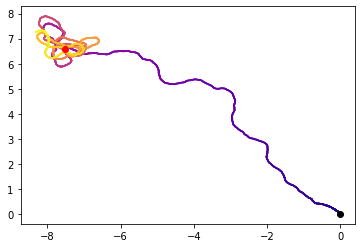

In [12]:
a = Vehicle()
b = Light()
duration = 5000
xpos = np.zeros(duration)
ypos = np.zeros(duration)
for t in range(duration):
    a.sense(b)
    a.think("c")
    a.move()
    xpos[t] = a.xpos
    ypos[t] = a.ypos
plt.plot(0.0,0.0,"ko")
plt.scatter(xpos,ypos,s=0.5,c=range(duration),cmap="plasma")
plt.plot(b.x,b.y,"ro")
plt.show()

(3 points) Second, if you ran the same experiment 100 times, with lights placed in different random locations (but at the same initial distance from the vehicle), what does the plot of the average distance of the vehicle to the light over time look like?  If your vehicle can find the light, then this plot should start at the initial distance (10 units of space at time zero) and then progressively get closer and closer to the light source, nearing 0 distance. 

In [7]:
def simulate(reps=100, model="c"):
    for _ in range(reps):
        a = Vehicle()
        # The question indicates random light positions
        b = Light()
        duration = 5000
        dists = np.zeros(duration)
        for t in range(duration):
            a.sense(b)
            a.think(model=model)
            a.move()
            dists[t] = np.sqrt( (a.xpos - b.x)**2 + (a.ypos - b.y)**2 )

        plt.plot(dists, c="b", alpha=0.15)
    plt.xlabel("Time")
    plt.ylabel("Distance")
    plt.title(f"Distance over time, {reps} simulations, model ({model})")
    plt.show()

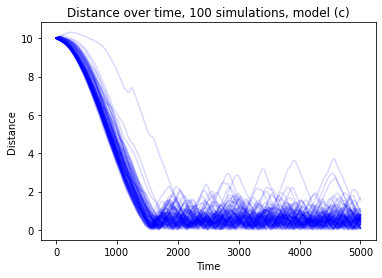

In [157]:
# My actual response to this question
simulate(reps=100, model="c")

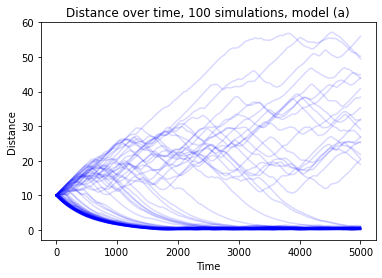

In [158]:
# To show the shortcomings of model (a)
simulate(reps=100, model="a")

(6 points) Final, open ended question: Choose your own adventure. Attempt to explore a different vehicle or attempt to answer any other additional question about this autonomous agent. For example, what is the role of noise on the orientation? Does noise help the agent do a better job at finding the light or does it hinder it? What is the effect of the amount of noise on the performance of this lightfinder. Or, can this same agent find a light that is moving randomly while the agent is try to find it? Show your work. Discuss your findings.

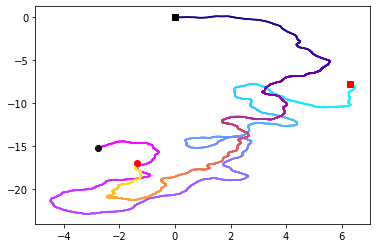

In [67]:
# I like the idea of a moving Light. I will make a Light that moves randomly,
# immediately after the agent moves.
# Essentially this agent is chasing something similar to a random walker. A
# random runner, if you will.
# It's interesting to see how much the trajectory of the agent changes when it
# gets especially close to the moving light. Sometimes, when the agent meets the
# moving light early in its time, it will follow it around (like the plot
# below)! This is especially interesting. It would be cool to simulate, perhaps,
# if the moving light were a source of some sort of vital resource and the agent
# that we're studying here were a being that needed that resource to survive.
# Perhaps we could study the optimal number of co-existing agents (who share
# this resource) per moving light source, given its output of the resource per
# time and its speed and degree of randomness.
#
# The trajectories have a square for the starting position, and a circle for the
# ending position. The trajectory with the red markers is the light, and the
# trajectory with the black markers is the agent.


class MovingLight(Light):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.orientation = np.random.random() * 2 * np.pi
    
    def move(self):
        self.orientation += np.random.normal(0, 0.1)
        speed = 0.01
        self.x += speed * np.cos(self.orientation)
        self.y += speed * np.sin(self.orientation)

a = Vehicle()
b = MovingLight()
bx0, by0 = b.x, b.y
duration = 5000
ax = np.zeros(duration)
ay = np.zeros(duration)
bx = np.zeros(duration)
by = np.zeros(duration)
for t in range(duration):
    a.sense(b)
    a.think("a")
    a.move()
    b.move()
    ax[t] = a.xpos
    ay[t] = a.ypos
    bx[t] = b.x
    by[t] = b.y
plt.plot(0.0,0.0,"ks")
plt.plot(bx0,by0,"rs")
plt.scatter(bx,by,s=0.5,c=range(duration),cmap="cool")
plt.scatter(ax,ay,s=0.5,c=range(duration),cmap="plasma")
plt.plot(a.xpos,a.ypos,"ro")
plt.plot(b.x,b.y,"ko")
plt.show()